In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


data = pd.read_csv("MALRatings.csv")
data

,Title,Genres,Rank,Popularity,Score,Episodes,Episode length,Release Date
0,Kaguya-sama wa Kokurasetai: Ultra Romantic,"Comedy,Suspense",13,404,8.99,12,23 min. per ep.,Spring 2022
1,3-gatsu no Lion 2nd Season,"Drama,Slice of Life",14,533,8.96,22,25 min. per ep.,Fall 2017
2,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,"Action,Comedy,Sci-Fi",19,939,8.93,1,1 hr. 50 min.,NaN
3,Gintama.,"Action,Comedy,Sci-Fi",12,735,8.99,12,24 min. per ep.,Winter 2017
4,Koe no Katachi,NaN,15,19,8.96,1,2 hr. 10 min.,NaN
...,...,...,...,...,...,...,...,...
20338,Steins;Gate,"Drama,Sci-Fi,Suspense",4,13,9.08,24,24 min. per ep.,Spring 2011
20339,High Score,"Comedy,Slice of Life",10527,6095,5.58,8,3 min. per ep.,Fall 2011
20340,Noraneko,NaN,8706,5064,6.04,1,35 sec.,NaN
20341,"Suki de Suki de, Suki de The Animation",NaN,/A,5329,6.81,2,27 min. per ep.,NaN


In [26]:
def convert_to_minutes(duration_str):
    if pd.isna(duration_str) or duration_str == 'Unknown':
        return np.nan
    return int(duration_str.split()[0])

In [27]:
data['Episode length'] = data['Episode length'].apply(convert_to_minutes)

data[['Popularity', 'Score', 'Episodes']] = data[['Popularity', 'Score', 'Episodes']].replace('Unknown', np.nan).astype(float)
data[['Popularity', 'Score', 'Episodes', 'Episode length']] = data[['Popularity', 'Score', 'Episodes', 'Episode length']].fillna(data.mean())
scaler = MinMaxScaler()
data[['Popularity', 'Score', 'Episodes', 'Episode length']] = scaler.fit_transform(data[['Popularity', 'Score', 'Episodes', 'Episode length']])

In [28]:
query_1 = {"Title": "Naruto", "Genres": "Action, Adventure, Shounen"}
query_2 = {"Title": "One Punch Man", "Genres": "Action, Comedy, Parody"}
query_3 = {"Title": "Death Note", "Genres": "Mystery, Psychological, Supernatural"}
queries = [query_1, query_2, query_3]


In [29]:
def jaccard_similarity(str1, str2):
    if pd.isna(str1) or pd.isna(str2):
        return 0
    set1 = set(str1.split(", "))
    set2 = set(str2.split(", "))
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [30]:
def calculate_similarity(query, data):
    data["Genre_Similarity"] = data["Genres"].apply(lambda x: jaccard_similarity(x, query["Genres"]))

    query_features = data[data["Title"] == query["Title"]][['Popularity', 'Score', 'Episodes', 'Episode length']].values

    data["Cosine_Similarity"] = cosine_similarity(data[['Popularity', 'Score', 'Episodes', 'Episode length']].values, query_features)
    data["Euclidean_Distance"] = euclidean_distances(data[['Popularity', 'Score', 'Episodes', 'Episode length']].values, query_features)

    data["Similarity_Score"] = (data["Cosine_Similarity"] + data["Genre_Similarity"]) - data["Euclidean_Distance"]


In [31]:
for query in queries:
    calculate_similarity(query, data)
    top_10_similar = data.nlargest(10, "Similarity_Score")[["Title", "Genres", "Rank", "Similarity_Score"]]
    print(f"Top 10 similar shows to {query['Title']}:\n")
    print(top_10_similar)
    print("\n")


Top 10 similar shows to Naruto:

                        Title  \
19827                  Naruto   
19991            Black Clover   
19828             Dragon Ball   
19668                InuYasha   
20027  Katekyo Hitman Reborn!   
20022           Dragon Ball Z   
19891              D.Gray-man   
19698                  Bleach   
19158              Fairy Tail   
19534                 Ranma ½   

                                                  Genres  Rank  \
19827                           Action,Adventure,Fantasy   603   
19991                              Action,Comedy,Fantasy   410   
19828                           Adventure,Comedy,Fantasy   617   
19668  Action,Adventure,Comedy,Fantasy,Romance,Supern...   794   
20027                                      Action,Comedy   393   
20022                    Action,Adventure,Comedy,Fantasy   376   
19891                            Action,Adventure,Comedy   522   
19698                           Action,Adventure,Fantasy   774   
19158    

In [32]:
def plot_similarity(queries, data):
    plt.figure(figsize=(10, 6))

    colors = ['r', 'g', 'b']
    markers = ['o', 's', 'D']

    for idx, query in enumerate(queries):
        calculate_similarity(query, data)
        top_10_similar = data.nlargest(10, "Similarity_Score")
        x = top_10_similar["Cosine_Similarity"]
        y = top_10_similar["Genre_Similarity"]

        plt.scatter(x, y, color=colors[idx], marker=markers[idx], label=query['Title'], alpha=0.7)

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Genre Similarity (Jaccard Index)")
    plt.legend()
    plt.title("Similarity Scores for Top 10 Similar Shows for Each Query")
    plt.show()

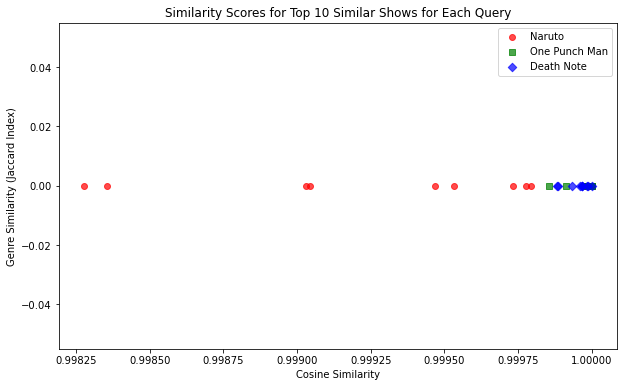

In [33]:
plot_similarity(queries, data)